# Lab 4 Individual Analysis - Muon Lifetime

This exercise will continue with the problem of calibration curves and data transformations.  You will also expand your use of the **lmfit** package.

In [1]:
import numpy as np  # import the numpy library functions.
import scipy.constants as const # import physical constants
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
# directive below puts the plots in the notebook
%matplotlib inline

## The calibration curve



### Enter the calibration data

Analyze the calibration data of TAC peaks that come from the Digital Delay Generator.  Then enter these results along with the known time values of 1.00, 2.00, ..., 9.00 microseconds to create two arrays: `cal_channels` and `cal_times`.

In [2]:
# Channels vs. time in microseconds from TAC calibration.

cal_data = np.array([[104.01,1.000],
                    [209.08,2.000],
                    [314.41,3.000],
                    [419.96,4.000],
                    [525.0, 5.000],
                    [630.0, 6.000],
                    [735.0, 7.000],
                    [840.03,8.000],
                    [945.08,9.000]])

# Array slicing separates channels from time values
cal_channels = cal_data[:,0]
cal_times = cal_data[:,1] # microseconds


### Fit and extract a calibration

Use LMFIT to fit the calibration data.  Obtain parameters that will allow you to convert a channel into a time in microseconds.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 9
    # variables        = 2
    chi-square         = 3.3051e-05
    reduced chi-square = 4.7216e-06
    Akaike info crit   = -108.632044
    Bayesian info crit = -108.237595
[[Variables]]
    slope:      0.00951120 +/- 2.6681e-06 (0.03%) (init = 0.009511198)
    intercept:  0.00918899 +/- 0.00157630 (17.15%) (init = 0.009188987)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.888


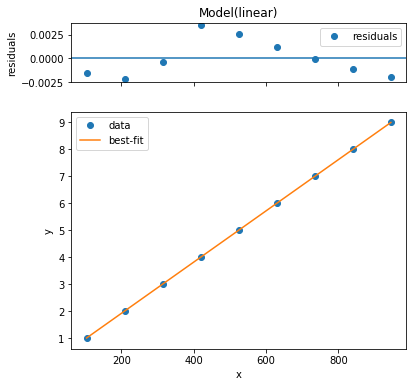

In [3]:
# imports a linear fitting model from lmfit
from lmfit.models import LinearModel

# create an instance of the model
cal_line = LinearModel()

param_guess = cal_line.guess(cal_times, x=cal_channels)
cal_line_fit = cal_line.fit(cal_times, param_guess, x=cal_channels)

print(cal_line_fit.fit_report())

#Then you can plot the results quickly just to see how it looks using the plot() method
cal_line_fit.plot();

### Save the fit parameters

Save the fit parameters and their `stderr`s as `uncertainties` objects.  This will allow you to easily propagate the uncertainties in the final values.

In [4]:
# Save fit parameters as uncertainty objects

cal_slope = unc.ufloat(cal_line_fit.params['slope'].value,cal_line_fit.params['slope'].stderr)
cal_intercept = unc.ufloat(cal_line_fit.params['intercept'].value,cal_line_fit.params['intercept'].stderr)

print(cal_slope,cal_intercept)

0.0095112+/-0.0000027 0.0092+/-0.0016


## Muon lifetime data, first pass

Import the muon lifetime data from the .mca file.  Use the Python package `mcareader` to do this.  To access the mcareader package, open a terminal window and type

`pip install mcareader`

You only need to do this once.  If you get an error when you try to import `mcareader`, you do not have it installed.

The cell below shows what using mcareader looks like, using the calibration data.  Note the use of the `Mca()` function and the return structures attributes.

For an example of how to use this small Python package, see the [mcareader documentation](https://github.com/Dih5/mcareader/blob/master/demos/intro.ipynb)

C:\Users\dbpengra\Anaconda3\lib\site-packages\mcareader.py:68: UserWarning: Warning: no calibration data was found. Using channel number instead of energy
  warnings.warn("Warning: no calibration data was found. Using channel number instead of energy")


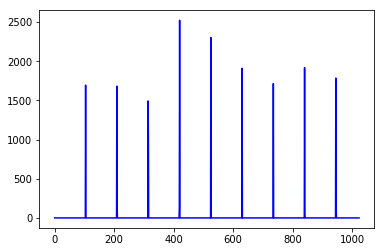

In [5]:
import mcareader as mca

TAC_cal = mca.Mca('MuLife_calibration_data.mca')

### Ignore warnings about missing calibration data.  ###

(TAC_x, TAC_y) = TAC_cal.get_points(trim_zeros=False)

plt.plot(TAC_x, TAC_y, '-b');

### Your turn: import and plot the muon lifetime data

Use what you learned in previous notebooks to plot the raw data set.  Remember to label the axes, etc.

In [6]:
# Import first

data_712ks = mca.Mca('MuLife_712ks.mca', calibration=None)

(x,y) = data_712ks.get_points(trim_zeros=False)


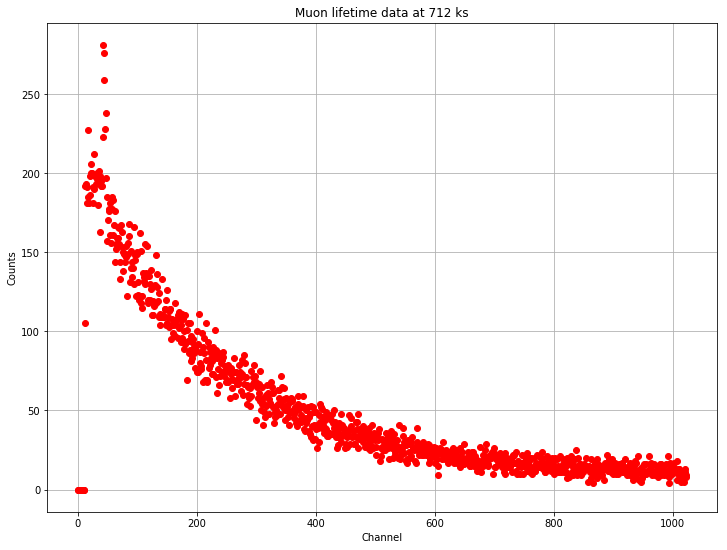

In [7]:
# Then plot

description = data_712ks.get_variable('DESCRIPTION')
plt.figure(figsize=(12,9))
plt.grid(True)
# plt.xlabel(r'Time ($\mu$s)')
plt.xlabel(r'Channel')
plt.ylabel(r'Counts')
#plt.xlim(0,60)
#plt.title(r'Muon Lifetime Measurement at 712,000 seconds')
plt.title(description)
plt.plot(x,y,'ro');

### Remove the bad data

Study the data set and extract the "good" part of the data, above the spike at around channel 45.  Use a Python "slice" to do this, and replot it to make sure you have a decent set of trimmed data.

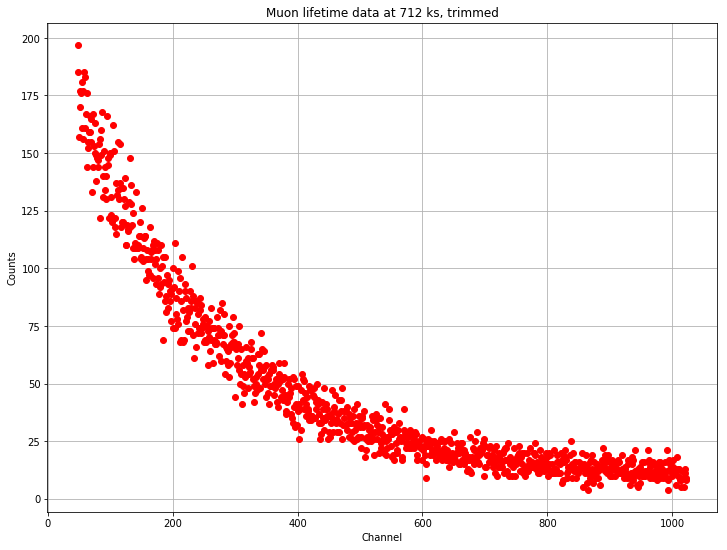

In [8]:
#trim_x = x[13:41]
#trim_x = np.append(trim_x, x[48:])
#trim_y = y[13:41]
#trim_y = np.append(trim_y, y[48:])

trim_x = x[48:]
trim_y = y[48:]
plt.figure(figsize=(12,9))
plt.grid(True)
# plt.xlabel(r'Time ($\mu$s)')
plt.xlabel(r'Channel')
plt.ylabel(r'Counts')
#plt.xlim(0,60)
plt.title(description+', trimmed')
plt.plot(trim_x,trim_y,'ro');

## Data fitting, part 1
Fit the trimmed data to an exponential decay plus a constant background term:

$$ N(x) = Ae^{-x/\tau} + C $$

producing parameters $A$, $C$, and $\tau$ in channel units.

Do this by using the LMFIT built in models to create a "composite" model with `ExponentialModel` plus `ConstantModel`.  See LMFIT [Built-in Fitting Models](https://lmfit.github.io/lmfit-py/builtin_models.html) for an example that combines a peak model with a background model.

You will need to set the starting values of the `amplitude` ($A$), the `decay` ($\tau$) and the background constant `c` ($C$).  The `guess()` method to set the parameters will not work on composite models.  These are not hard to estimate from the data plot. Look at the plot to estimate staring values for `c`, `decay`, and `amplitude`.  Call them `start_c`, `start_ampl`, and `start_decay`. Then you can call the fit routine with

`model_fit = model.fit(trim_y, c=start_c, amplitude=start_ampl, decay=start_decay, x=trim_x)`


In [9]:
# from lmfit.models import ExpressionModel
from lmfit.models import ExponentialModel, ConstantModel

decay = ExponentialModel()
background = ConstantModel()
model = decay + background

model_fit = model.fit(trim_y, c=5.0, amplitude=200.0, decay=200.0, x=trim_x)

print(model_fit.fit_report())


[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 976
    # variables        = 3
    chi-square         = 42966.7350
    reduced chi-square = 44.1590288
    Akaike info crit   = 3699.88565
    Bayesian info crit = 3714.53604
[[Variables]]
    amplitude:  202.648929 +/- 1.42122172 (0.70%) (init = 200)
    decay:      219.690022 +/- 2.84506805 (1.30%) (init = 200)
    c:          9.79747955 +/- 0.47113486 (4.81%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.798
    C(amplitude, decay) = -0.673
    C(amplitude, c)     =  0.241


### Replot, with a fitline

Use the `eval()` function to msake a fit line, and plot it with the data.

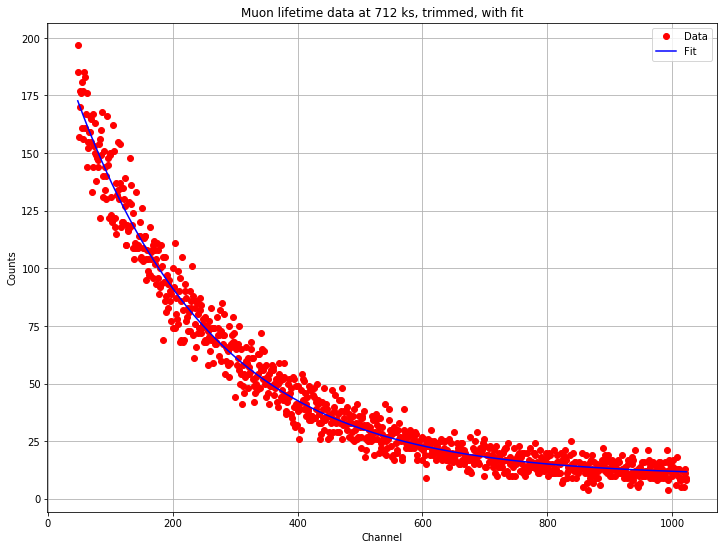

In [10]:
fitline1 = model.eval(model_fit.params,x=trim_x)

plt.figure(figsize=(12,9))
plt.grid(True)
# plt.xlabel(r'Time ($\mu$s)')
plt.xlabel(r'Channel')
plt.ylabel(r'Counts')
#plt.yscale('log')
plt.title(description+', trimmed, with fit')
plt.plot(trim_x, trim_y,'ro', label='Data')
plt.plot(trim_x, fitline1, 'b-', label='Fit')
plt.legend();

### Calculate the lifetime

Combine the fit results and the calibration constants along with their uncertainties to calculate a value for the lifetime and background term, including uncertainties.  Print these out with correct significant figures.  (Use the `uncertainties` package.) 

In [11]:
T1 = unc.ufloat(model_fit.params['decay'].value,model_fit.params['decay'].stderr)
lifetime1 = cal_slope*T1 + cal_intercept
print('Data analysis, version 1:')
print('    Muon lifetime = {:.2uP} microseconds'.format(lifetime1))
B1 = unc.ufloat(model_fit.params['c'].value,model_fit.params['c'].stderr)
print('    Background counts = {:.2uP}'.format(B1))

Data analysis, version 1:
    Muon lifetime = 2.099±0.027 microseconds
    Background counts = 9.80±0.47


## Data fitting part 1-A

Redo the fit above, but include weights for the fitting routine.  The weights should be an array, with each element being $1/\sigma_i$, where $\sigma_i$ is the uncertainty in the point.

Because this is an experiment based on random statitistics, the uncertainty in any channel is the square root of the number of counts in that channel.  This is a consequence of Poisson statistics.  So the weights array can be specified as `weights = 1.0/np.sqrt(trim_y)` where `trim_y` is the array of trimmed chanel counts.

NOTE: If you get an error about dividing by zero, either make sure you have no zeros in your data set, or add the following argument to the `fit()` function: `nan_policy='omit'`.

In [12]:
model_fit = model.fit(trim_y, c=5.0, amplitude=200.0, decay=200.0, x=trim_x, weights = 1.0/np.sqrt(trim_y))

print(model_fit.fit_report())

[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 976
    # variables        = 3
    chi-square         = 979.813517
    reduced chi-square = 1.00700259
    Akaike info crit   = 9.80608607
    Bayesian info crit = 24.4564738
[[Variables]]
    amplitude:  201.078206 +/- 2.19042305 (1.09%) (init = 200)
    decay:      223.690111 +/- 2.99938987 (1.34%) (init = 200)
    c:          8.31310242 +/- 0.31857655 (3.83%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.813
    C(amplitude, decay) = -0.777
    C(amplitude, c)     =  0.430


### Recalculate the lifetime, from the results of the weighted fit.

Redo what you did above to obtain a new version of the lifetime, based on the weighted fit.

In [13]:
T1a = unc.ufloat(model_fit.params['decay'].value,model_fit.params['decay'].stderr)
lifetime1a = cal_slope*T1a + cal_intercept
print('Data analysis, version 1-A:')
print('    Muon lifetime = {:.2uP} microseconds'.format(lifetime1a))
B1a = unc.ufloat(model_fit.params['c'].value,model_fit.params['c'].stderr)
print('    Background counts = {:.2uP}'.format(B1a))

Data analysis, version 1-A:
    Muon lifetime = 2.137±0.029 microseconds
    Background counts = 8.31±0.32


### Compare version 1 and version 1-A

Look at the `fit_report()` and comment below about the $\chi^2$ (chi-square) statistics for each version of the fit: Note the differences, and explain them.

### $\rightarrow$ Click on this to open a cell to write your discussion $\leftarrow$ 

## Data fitting, part 2

Based on the record of **C-Singles**, **Valid Starts**, **Valid Conversions**, and **Elapsed Time**, your group should calculate an expected background level, per channel, for the experiment. 

Then, use that estimate in the fit as follows.  Obtain the **Parameters** structure from the previous fit, and for marameter `c` (the background constant), set its `vary` attribute to `False`, and then its `value` attribute to your expected background level.  

Feed the revised parameters into the `fit()` function, and redo the fit.  (You may leave the weight in place, or not, your choice).

Scroll to the bottom of [Getting started with Non-Linear Least-Squares Fitting](https://lmfit.github.io/lmfit-py/intro.html) to see an example of controlling the parameters.

In [14]:
# Obtain the current fit parameters
params = model_fit.params

# You do the rest
# I calculate that the counts/channel for background should be about 9.0

params['c'].vary = False
params['c'].value = 9.0
params.pretty_print(columns=['value','vary'])

model_fit = model.fit(trim_y, params, x=trim_x, nan_policy='omit', weights=1/np.sqrt(trim_y))

print(model_fit.fit_report())

Name          Value     Vary
amplitude     201.1     True
c                 9    False
decay         223.7     True
[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 976
    # variables        = 2
    chi-square         = 984.610448
    reduced chi-square = 1.01089368
    Akaike info crit   = 12.5726880
    Bayesian info crit = 22.3396132
[[Variables]]
    amplitude:  203.134290 +/- 2.03035268 (1.00%) (init = 201.0782)
    decay:      218.482313 +/- 1.73435772 (0.79%) (init = 223.6901)
    c:          9 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay) = -0.813


### Compare the fit curves

Create another fitline, based on the fit result with the fixed background term, and plot it over the data, along with the original fitline.

Your group will want to discuss these in the group document.

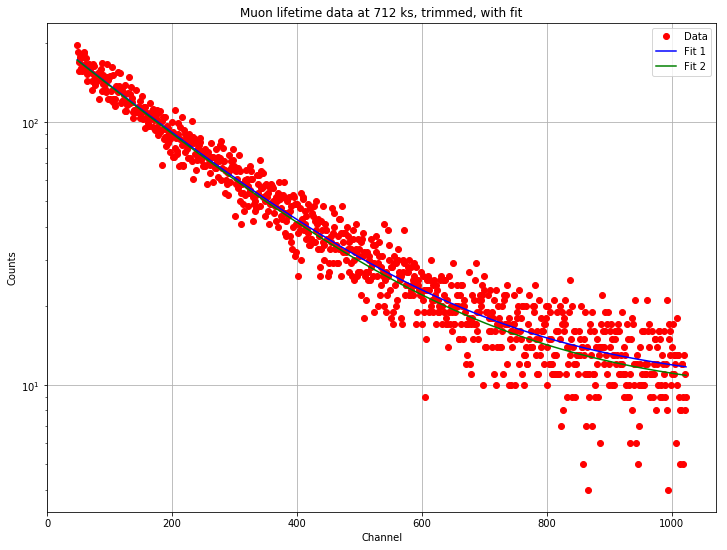

In [15]:
fitline2 = model.eval(model_fit.params,x=trim_x)

plt.figure(figsize=(12,9))
plt.grid(True)
# plt.xlabel(r'Time ($\mu$s)')
plt.xlabel(r'Channel')
plt.ylabel(r'Counts')
plt.yscale('log')
plt.title(description+', trimmed, with fit')
plt.plot(trim_x, trim_y,'ro', label='Data')
plt.plot(trim_x, fitline1, 'b-', label='Fit 1')
plt.plot(trim_x, fitline2, 'g-', label='Fit 2')
plt.legend();

### Calculate the lifetime (again)

From the fit, calculate another value for the lifetime (with uncertainty).

In [16]:
T2 = unc.ufloat(model_fit.params['decay'].value,model_fit.params['decay'].stderr)
lifetime2 = cal_slope*T2 + cal_intercept
print('Data analysis, version 2:')
print('    Muon lifetime = {:.2uP} microseconds'.format(lifetime2))
B2 = unc.ufloat(model_fit.params['c'].value,model_fit.params['c'].stderr)
print('    Background counts = {:.2uP}'.format(B2))

Data analysis, version 2:
    Muon lifetime = 2.087±0.017 microseconds
    Background counts = 9.0±0


## Data fitting, part 3

Here, you want to manipulate the data set to create a new set of data, by "coarse binning".  This means to combine the counts from adajacent channels into a single new channel.  For example, with 1024 channels, one could "rebin" by summing channels 0-15 into one bin, 16-31 in the next, 32-47 in the third, etc.  This would reduce the data set from 1024 channels to 64 channels.  By adding in this way, the scatter of the data set is reduced.  One must also adjust the `x` or channel values similarly, otherwise, the data set is scaled horizontally, and the channel-time calibration will not work.

In the following, you will write a function to rebin the data by summing over successive channels and rescaling the channel numbers.  Then you will plot and fit the results, as before, and see whether this improves anything.

### Write a function `coarse_bin()`

Define a function with the folowing specifications:

* Arguments:
  * **x** : array of *x* or channel numbers
  * **y** : array of *y* or count numbers
  * **binwidth** : the width of the new bins, or number of channels to sum together

* Returns:
  * **new_x, new_y**: A tuple of Numpy arrays of the average values of <i>x</i> and sum of values of <i>y</i>, across the number of summed channels.

In [17]:
# My version has a few more options
#
def coarse_bin(x, y, binwidth=None, bins=None, average=False):
    if binwidth:
        bins = len(x)//binwidth
    elif bins:
        binwidth = len(x)//bins
    else:
        binwidth = 1
        bins = len(x)
    coarse_x = []
    coarse_y = []
    for i in range(bins):
        coarse_x.append(np.mean(x[i*binwidth:(i+1)*binwidth]))
        if average :
            coarse_y.append(np.mean(y[i*binwidth:(i+1)*binwidth]))
        else:
            coarse_y.append(np.sum(y[i*binwidth:(i+1)*binwidth]))
    return (np.array(coarse_x),np.array(coarse_y))

### Apply your function

Test your function, and see that it works correctly.  Then plot the rebinned data.

In [18]:
newx, newy = coarse_bin(trim_x,trim_y,binwidth=16,average=False)

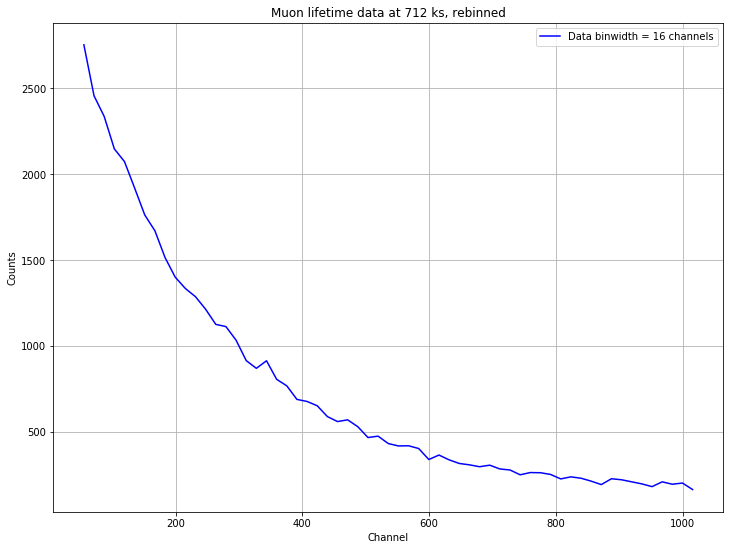

In [19]:
plt.figure(figsize=(12,9))
plt.grid(True)
# plt.xlabel(r'Time ($\mu$s)')
plt.xlabel(r'Channel')
plt.ylabel(r'Counts')
# plt.yscale('log')
plt.title(description+', rebinned')
#plt.plot(trim_x,trim_y,'r-', label='Original data')
plt.plot(newx,newy,'b-', label='Data binwidth = 16 channels')
plt.legend();

### Fit it

Use the plot you made to estimate the starting values of the parameters for the rebinned data set.  Then fit it and extract a value for the lifetime, as you did above.

[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 61
    # variables        = 3
    chi-square         = 46.8725993
    reduced chi-square = 0.80814826
    Akaike info crit   = -10.0698763
    Bayesian info crit = -3.73725472
[[Variables]]
    amplitude:  3220.45474 +/- 31.7296649 (0.99%) (init = 2700)
    decay:      222.956347 +/- 2.72554512 (1.22%) (init = 200)
    c:          150.078418 +/- 4.70478870 (3.13%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.812
    C(amplitude, decay) = -0.776
    C(amplitude, c)     =  0.426


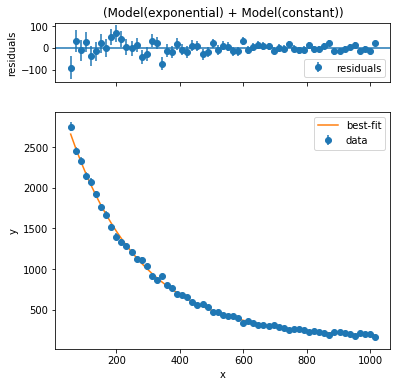

In [20]:
model_fit = model.fit(newy, c=200.0, decay=200.0, amplitude=2700.0, x=newx, nan_policy='omit', weights=1.0/np.sqrt(newy))

print(model_fit.fit_report())

model_fit.plot();

### Plot the rebinned data and the fit

If you have not done so already, plot the rebinned data and its fit curve.

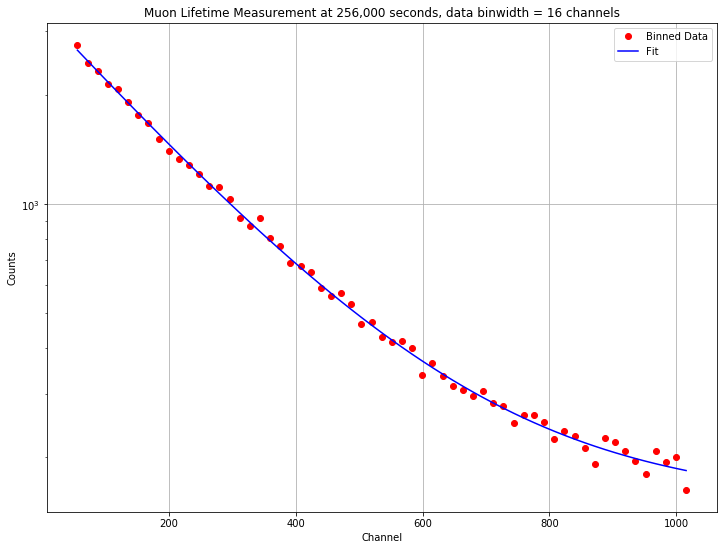

In [21]:
fitline3 = model.eval(model_fit.params,x=newx)

plt.figure(figsize=(12,9))
plt.grid(True)
# plt.xlabel(r'Time ($\mu$s)')
plt.xlabel(r'Channel')
plt.ylabel(r'Counts')
plt.yscale('log')
plt.title(r'Muon Lifetime Measurement at 256,000 seconds, data binwidth = 16 channels')
plt.plot(newx, newy,'ro', label='Binned Data')
plt.plot(newx, fitline3, 'b-', label='Fit')
plt.legend();

### Calculate lifetime and background with rebinned data

In [22]:
T3 = unc.ufloat(model_fit.params['decay'].value,model_fit.params['decay'].stderr)
lifetime3 = cal_slope*T3 + cal_intercept
print('Data analysis, version 3:')
print('    Muon lifetime = {:.2uP} microseconds'.format(lifetime3))
B3 = unc.ufloat(model_fit.params['c'].value,model_fit.params['c'].stderr)
print('    Background counts = {:.2uP}'.format(B3))

Data analysis, version 3:
    Muon lifetime = 2.130±0.026 microseconds
    Background counts = 150.1±4.7


## Muon lifetime calculation summary
Make a table with the muon lifetimes computed in steps 1, 1a, 2 and 3.
Calculated value of muon lifetime and background rate, including uncertainty.

In [23]:
print('Collected results for muon lifetime')
print('Version      |  Lifetime (us)    | Background (cts/bin)')
print('-------------|-------------------|----------------------')
print('1 (raw data) | {:.2uP}       | {:.2uP}'.format(lifetime1,B1))
print('1a (weighted)| {:.2uP}       | {:.2uP}'.format(lifetime1a,B1a))
print('2 (fixed Bkg)| {:.2uP}       | {:.2uP}'.format(lifetime2,B2))
print('3 (rebinned) | {:.2uP}       | {:.2uP}'.format(lifetime3,B3))

Collected results for muon lifetime
Version      |  Lifetime (us)    | Background (cts/bin)
-------------|-------------------|----------------------
1 (raw data) | 2.099±0.027       | 9.80±0.47
1a (weighted)| 2.137±0.029       | 8.31±0.32
2 (fixed Bkg)| 2.087±0.017       | 9.0±0
3 (rebinned) | 2.130±0.026       | 150.1±4.7
